# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [155]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn import metrics, datasets
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import datetime as dt
import plotly.offline as pyoff
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

In [156]:
def histogram(col_name, df):
    plot_data = [go.Histogram(x=df[col_name])]
    plot_layout = go.Layout(title=col_name)
    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

In [157]:
def elbow(col_name, df):        
    inertia={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=100).fit(df[[col_name]])
        inertia[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(inertia.keys()), list(inertia.values()))
    plt.xlabel("Number of cluster")
    plt.show()

In [158]:
def order_cluster(cluster_col, attribute, df, ascending):
    new_cluster_col = 'new_' + cluster_col
    df_tmp = df.groupby(cluster_col)[attribute].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=attribute, ascending=ascending).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index
    df_out = pd.merge(df,df_tmp[[cluster_col,'index']], on=cluster_col)
    df_out = df_out.drop([cluster_col],axis=1)
    df_out = df_out.rename(columns={"index":cluster_col})
    return df_out

In [159]:
def scatter(col_name, cluster_col_name, x, y, df):

    display(df.groupby(cluster_col_name)[col_name].describe())
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df[x], df[y],
                         c=df[cluster_col_name], s=2)
    ax.set_title('K-Means Clustering')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.colorbar(scatter)

In [160]:
df = pd.read_csv('eshop.csv')
today = dt.datetime.strptime('12/19/2015', '%m/%d/%Y')

# RECENCY
Nájdem posledný nákup (max Date) a odpočítam od neho posledný nákup každého zákazníka - získam koľko dní bolo od z. posledného nákupu

In [161]:
df['Date'] = pd.to_datetime(df['Date'])

In [162]:
users = pd.DataFrame(df['Customer ID'].unique())
users.columns = ['Customer ID']
last_buy = df.groupby('Customer ID').Date.max().reset_index()
last_buy.columns = ['Customer ID','LastPurchase']
last_buy['LastPurchase'] = pd.to_datetime(last_buy['LastPurchase'], format='%m/%d/%Y')
last_buy['Recency'] = (today - last_buy['LastPurchase']).dt.days

In [163]:
df = pd.merge(df, last_buy[['Customer ID','Recency']], on='Customer ID')

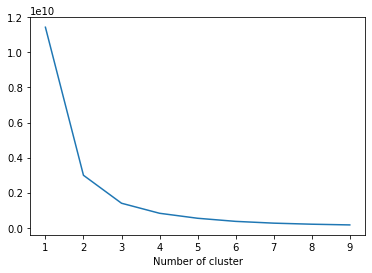

In [164]:
histogram('Recency', df)
elbow('Recency', df)

In [165]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Recency']])
df['R cluster n.'] = kmeans.predict(df[['Recency']])

,count,mean,std,min,25%,50%,75%,max
R cluster n.,,,,,,,,
0,8160.0,197.468137,152.500931,0.0,56.0,165.0,337.0,490.0
1,5375.0,780.110884,167.505607,491.0,634.0,775.0,921.5,1095.0
2,5417.0,1404.093410,194.674456,1096.0,1227.0,1398.0,1550.0,1765.0
3,3456.0,2120.787616,282.533574,1766.0,1893.0,2049.0,2277.0,3103.0


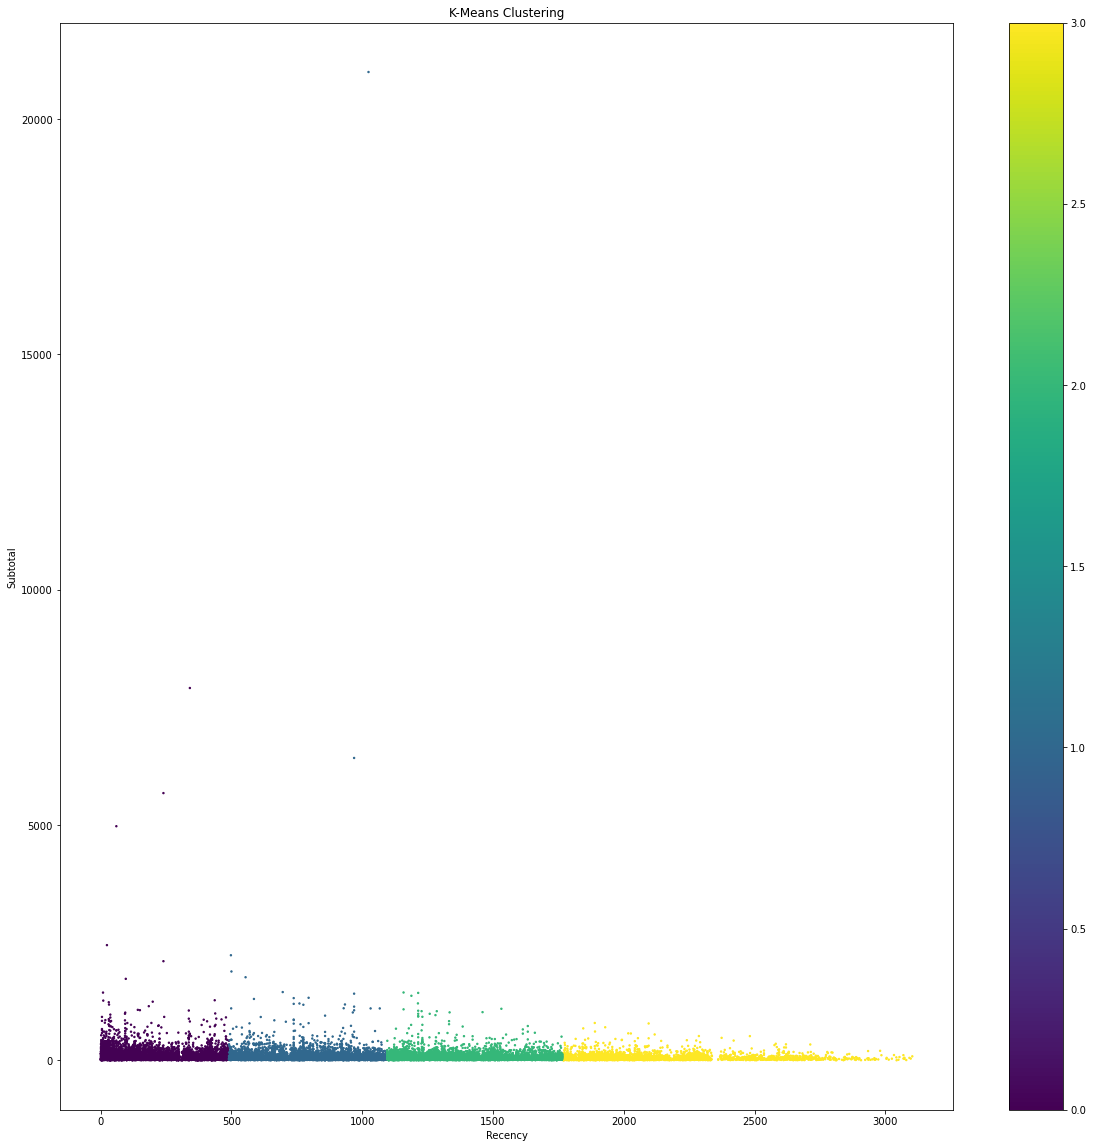

In [166]:
dfR = order_cluster('R cluster n.', 'Recency', df, True)
scatter('Recency', 'R cluster n.', 'Recency', 'Subtotal', dfR)

# FREQUENCY

In [167]:
#get order counts for each user and create a dataframe with it
frequency = df.groupby('Customer ID').Subtotal.count().reset_index()
frequency.columns = ['Customer ID', 'Frequency']
df = pd.merge(df, frequency, on='Customer ID')

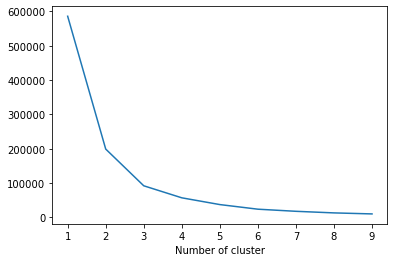

In [168]:
histogram('Frequency', df)
elbow('Frequency', df)

In [169]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Frequency']])
df['F cluster n.'] = kmeans.predict(df[['Frequency']])

,count,mean,std,min,25%,50%,75%,max
F cluster n.,,,,,,,,
0,568.0,25.816901,6.416051,20.0,22.0,24.0,27.0,45.0
1,1926.0,12.853583,2.462256,10.0,11.0,12.0,14.0,19.0
2,4831.0,5.863589,1.671903,4.0,4.0,5.0,7.0,9.0
3,15083.0,1.539548,0.738397,1.0,1.0,1.0,2.0,3.0


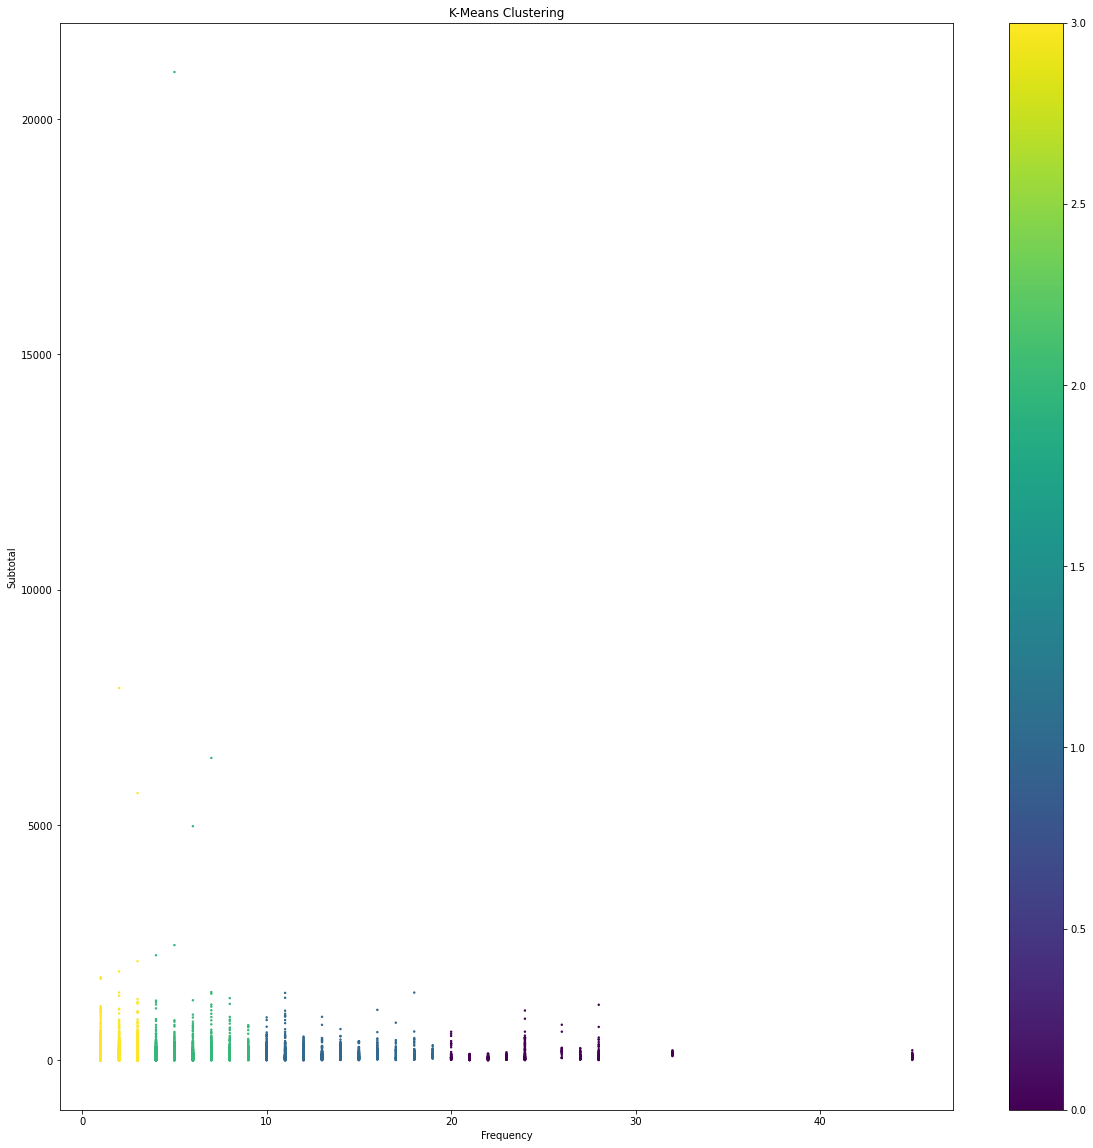

In [170]:
dfRL = order_cluster('F cluster n.', 'Frequency', df, False)
scatter('Frequency', 'F cluster n.', 'Frequency', 'Subtotal', dfRL)